Proyecto 1: Bioseñales y Sistemas


> Presentado por: Angie Melissa Londoño Castaño



Inicialmente se deben importar las librerias con las que se ejecutaron todos los códigos, las cuales son: numpy, scipy, matplotlib, glob y pandas. También se cargan a este archivo los datos con los cuales se trabajó, que corresponden a 36 pacientes de control y 23 pacientes de parkinson.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Manejo de elementos del sistema, como carpetas
# Se importan las librerias
import scipy.io as sio;
import numpy as np;
import matplotlib.pyplot as plt
import glob
import pandas as pd

# Se importan los archivos
archivos_g1 = glob.glob('/content/drive/Shareddrives/biosenales_sistemas/datasets_proyecto1/control/*.mat')
archivos_g2 = glob.glob('/content/drive/Shareddrives/biosenales_sistemas/datasets_proyecto1/parkinson/*.mat')
print('Hay ' + str(len(archivos_g1)) + ' sujetos de control')     # Hay 36 sujetos de control
print('Hay ' + str(len(archivos_g2)) + ' sujetos de parkinson')     # Hay 23 sujetos de parkinson

fs = 1000     # Frecuencia de muestreo

# Los siguientes archivos se usaron para probar el funcionamiento de los códigos
archivo1 = sio.loadmat(archivos_g1[1])    # Este es un diccionario con los datos que representa a un paciente particular
archivo2 = sio.loadmat(archivos_g2[1])
control1 = archivo1['data']       # Estos son los datos guardados en la clave 'data'
parkinson1=archivo2['data']

Mounted at /content/drive
Hay 36 sujetos de control
Hay 23 sujetos de parkinson


1. Crear una función que reciba una señal de EEG y permita calcular la entropía de permutación

In [ ]:
def Entropia_de_Permutacion (EEG):
  '''
  Esta funcion recibe un vector y retorna un flotante
  Usando D=3 y Tau=1
  '''
  s = np.array(EEG)     # Señal
  tamano = s.shape    # Tamaño de la señal
  indices = range(tamano[0]-1)     # Vector de indices
  matriz = [0,0,0]    # fila de ceros de tamaño 3x1
  for v in indices:     # Este ciclo se utiliza para la partición del espacio de estado, lo cual no puede hacerse con numpy
    vfila = [s[v-1],s[v],s[v+1]]
    matriz = np.vstack([matriz,vfila])    # Concatena cada fila y organiza una matriz
  matriz = matriz[2:,:]     # Recorta las dos primeras filas, pues no son utiles
  ncol = tamano[0]-2    # Numero de columnas de la matriz transpuesta
  pi1=0; pi2=0; pi3=0; pi4=0; pi5=0; pi6=0    # Inicialización de las permutaciones
  for fila in matriz:     # Este ciclo cuenta los Patrones ordinales, que no pueden hacerse con numpy
    if fila[0]<fila[1]<fila[2]:
      pi1 += 1
    if fila[0]<fila[2] and fila[1]>fila[2]:
      pi2 += 1
    if fila[1]<fila[0] and fila[0]<fila[2]:
      pi3 += 1
    if fila[1]>fila[0] and fila[0]>fila[2]:
      pi4 += 1
    if fila[1]<fila[2] and fila[0]>fila[2]:
      pi5 += 1
    if fila[1]<fila[0] and fila[2]<fila[1]:
      pi6 += 1
  pis = np.array([pi1,pi2,pi3,pi4,pi5,pi6])     # Vector de los numeros de incidentes
  PisMay0 = pis[pis>0]/ncol     # Frecuancias relativas de los pis mayores que 0
  PE = np.dot(np.log2(PisMay0),-PisMay0)    # Entropía de permutación
  #print('La entropía de permuntación es: ' + str(PE))
  #print('La entropía de permutación normalizada es: ' + str(0.386852*PE))
  return float(PE)

2. Crear una función que reciba una señal EEG de múltiples épocas y devuelva el promedio de la entropía de permutación calculado sobre cada época


In [ ]:
def promedio_EP_por_epoca (Sensor): #control o parkinson, esta es una matriz en 2D de (puntos x epocas)
  '''
  Esta función recibe una matriz 2D y retorna un numero
  '''
  Epocas = Sensor.shape[1]
  EPE = 0
  for e in range(Epocas):
    EPE += Entropia_de_Permutacion(Sensor[:,e])     # Entropia de Permutación por Epoca
  EPEP = EPE/Epocas     # Entropia de Permutacion por Epoca Promedio
  return EPEP

#promedio_EP_por_epoca(control1[0])      # Un ejemplo


3. Crear una función que reciba una señal EEG de múltiples canales y múltiples épocas y devuelva el promedio de la entropía de permutación calculado sobre cada época en cada canal por separado


In [ ]:
def promedio_EP_por_sensor_por_epoca(Matriz3D):
  '''
  Esta función recibe una matriz en 3D, que representa 1 solo paciente y retorna un matriz de sensores x epoca
  '''
  sensores = Matriz3D.shape[0]
  epocas = Matriz3D.shape[2]
  entropia_S_E = np.zeros((sensores,epocas))    # Matriz de ceros de sensores x epoca
  for s in range(sensores):
    for e in range(epocas):
      h = Entropia_de_Permutacion(Matriz3D[s,:,e])
    entropia_S_E[s,e] = h
  return entropia_S_E

#promedio_EP_por_sensor_por_epoca(control1)    # Ejemplo de 1 paciente (1 matriz 3D)

4. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 y almacene los resultados en un dataframe donde se pueda discriminar nombre, sujeto, control o paciente y el promedio de entropía de permutación obtenido para cada canal, por ejemplo (10):


In [ ]:
Pacientes = []
Pacientes.extend(archivos_g1)
Pacientes.extend(archivos_g2)     # Pacientes es una lista con todas las rutas de control + parkinson

control = np.zeros(len(archivos_g1))
parkinson = np.ones(len(archivos_g2))
Tipo_Paciente = np.hstack([control,parkinson])    # Si el valor es 0 es un paciente de control, si es 1 es un paciente de parkinson
Resultados=[0,0,0,0,0,0,0,0]

for ruta in Pacientes:
  indice = Pacientes.index(ruta)
  paciente = sio.loadmat(Pacientes[indice]); #Este es el archivo que está en la ruta
  data = paciente['data'];     # Este data es la matriz de sensor x puntos x epoca
  S_E = promedio_EP_por_sensor_por_epoca(data)
  Resultados = np.vstack([Resultados,np.mean(S_E, 1)])
Resultados = Resultados[1:,:]

tabla = pd.DataFrame({"Sujeto": range(Tipo_Paciente.shape[0]), "Estado": Tipo_Paciente,
                      "Entropia_Canal_1": Resultados[:,0], "Entropia_Canal_2": Resultados[:,1], "Entropia_Canal_3": Resultados[:,2],
                      "Entropia_Canal_4": Resultados[:,3], "Entropia_Canal_5": Resultados[:,4], "Entropia_Canal_6": Resultados[:,5],
                      "Entropia_Canal_7": Resultados[:,6], "Entropia_Canal_8": Resultados[:,7]})
print(tabla)



    Sujeto  Estado  ...  Entropia_Canal_7  Entropia_Canal_8
0        0     0.0  ...          0.007210          0.007131
1        1     0.0  ...          0.007085          0.007317
2        2     0.0  ...          0.008984          0.009018
3        3     0.0  ...          0.008879          0.008637
4        4     0.0  ...          0.007388          0.007561
5        5     0.0  ...          0.007586          0.007491
6        6     0.0  ...          0.009400          0.009240
7        7     0.0  ...          0.007158          0.007106
8        8     0.0  ...          0.007533          0.007537
9        9     0.0  ...          0.006810          0.006780
10      10     0.0  ...          0.009274          0.009316
11      11     0.0  ...          0.007967          0.007758
12      12     0.0  ...          0.006813          0.006706
13      13     0.0  ...          0.007890          0.007900
14      14     0.0  ...          0.007061          0.007052
15      15     0.0  ...          0.00626

Los siguientes códigos se usaron para sacar las graficas estadísticas

In [ ]:
#se crea la matriz grupal sujetos x canales
entropia_g1 = np.zeros((len(archivos_g1),control1.shape[0]))
contador = 0

#por cada archivo de G1 se hace el analisis espectral
for archivo in archivos_g1:
  #se trabaja este en la misma carpeta de los datos para que pueda funcionar
  archivo1 = sio.loadmat(archivos_g1[contador]);
  control1 = archivo1['data'];

  #%% CONTINUA
  sensores = control1.shape[0];
  puntos = control1.shape[1];
  epocas = control1.shape[2];

  for s in range(sensores):
    h = 0
    for e in range(epocas):
      h = h + Entropia_de_Permutacion(control1[s,:,e])
    h = h/epocas #promedio
    entropia_g1[contador,s] = h #se guarda la entropia del sujeto en el sensor s

  contador += 1

In [ ]:
#se crea la matriz grupal sujetos x canales
entropia_g2 = np.zeros((len(archivos_g2),parkinson1.shape[0]))
contador = 0

#por cada archivo de G1 se hace el analisis espectral
for archivo in archivos_g2:
  #se trabaja este en la misma carpeta de los datos para que pueda funcionar
  archivo2 = sio.loadmat(archivos_g2[contador]);
  parkinson1 = archivo2['data'];

  #%% CONTINUA
  sensores = parkinson1.shape[0];
  puntos = parkinson1.shape[1];
  epocas = parkinson1.shape[2];

  for s in range(sensores):
    h = 0
    for e in range(epocas):
      h = h + Entropia_de_Permutacion(parkinson1[s,:,e])
    h = h/epocas #promedio
    entropia_g2[contador,s] = h #se guarda la entropia del sujeto en el sensor s

  contador += 1

In [ ]:
promedio_g1 = np.mean(entropia_g1,axis=0) #se promedia sobre los sujetos
promedio_g2 = np.mean(entropia_g2,axis=0)

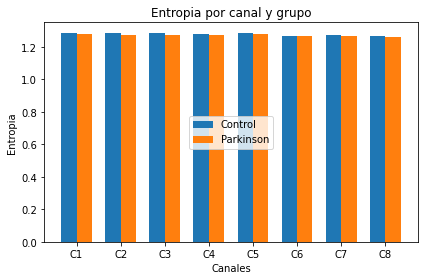

In [ ]:
labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, promedio_g1, width, label='Control')
rects2 = ax.bar(x + width/2, promedio_g2, width, label='Parkinson')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Entropia')
ax.set_xlabel('Canales')
ax.set_title('Entropia por canal y grupo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="center")

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

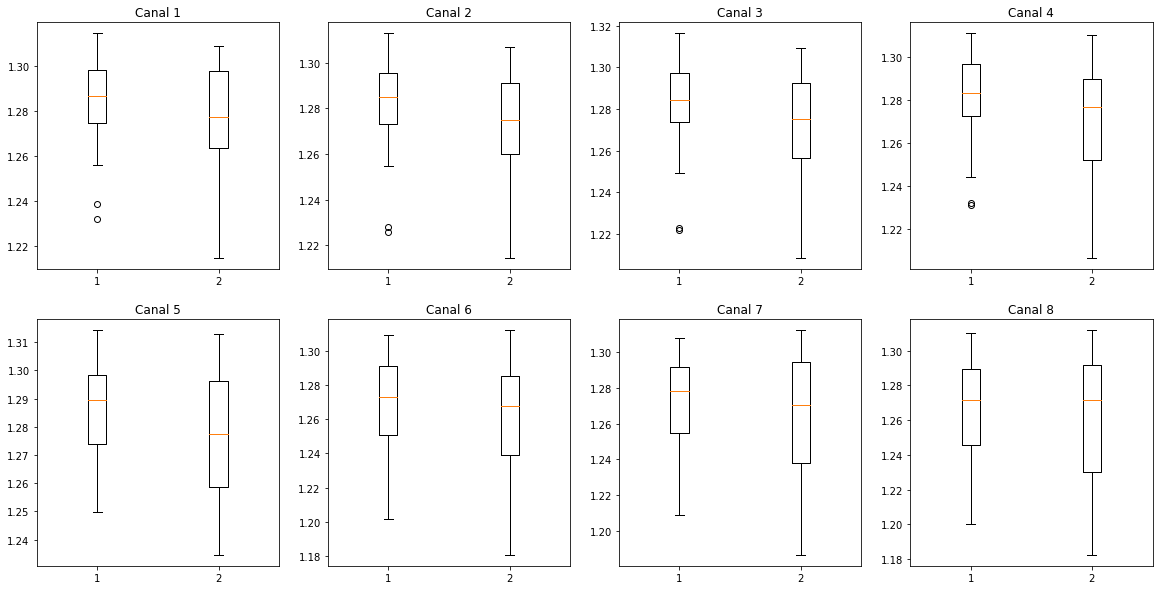

In [ ]:
# CAJAS Y BIGOTES POR CANAL PARA CONTROL Y PARKINSON
plt.figure(figsize=(20,10))
h=0
for i in range(1,9):
  data = [np.squeeze(entropia_g1[:,h]),np.squeeze(entropia_g2[:,h])]
  plt.subplot(2,4, i)
  plt.boxplot(data)
  plt.title('Canal ' +  str(i))
  h +=1

plt.show()

Pruebas de normalidad (Shapiro-Wilk) y prueba paramétrica (Mann-Whitney U). Dichas pruebas se realizaron con el fin de determinar la distribución que seguian los datos para cada grupo de sujetos, esto se evaluó por cada canal.

In [ ]:
# Shapiro-Wilk Normality Test (Sujetos control)
i=0
for i in range(sensores):
  from scipy.stats import shapiro
  data = np.squeeze(entropia_g1[:,i])
  stat, p = shapiro(data)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probabilidad Gaussina para el canal ' + str(i+1)+ ' de control')
  else:
	  print('Probabilidad no Gaussian para el canal '+ str(i+1)+' de control')
  i=i+1

stat=0.945, p=0.071
Probabilidad Gaussina para el canal 1 de control
stat=0.935, p=0.036
Probabilidad no Gaussian para el canal 2 de control
stat=0.938, p=0.043
Probabilidad no Gaussian para el canal 3 de control
stat=0.938, p=0.044
Probabilidad no Gaussian para el canal 4 de control
stat=0.961, p=0.232
Probabilidad Gaussina para el canal 5 de control
stat=0.940, p=0.051
Probabilidad Gaussina para el canal 6 de control
stat=0.935, p=0.035
Probabilidad no Gaussian para el canal 7 de control
stat=0.955, p=0.152
Probabilidad Gaussina para el canal 8 de control


In [ ]:
# Shapiro-Wilk Normality Test (Sujetos parkinson)
from scipy import stats
i=0
for i in range(sensores):
  from scipy.stats import shapiro
  data = np.squeeze(entropia_g2[:,i])
  stat, p = shapiro(data)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probabilidad Gaussiana para el canal '+ str(i+1)+' de parkinson')
  else:
	  print('Probabilidad no Gaussian para el canal '+ str(i+1)+' de parkinson')
  i=i+1

stat=0.924, p=0.081
Probabilidad Gaussiana para el canal 1 de parkinson
stat=0.926, p=0.091
Probabilidad Gaussiana para el canal 2 de parkinson
stat=0.940, p=0.178
Probabilidad Gaussiana para el canal 3 de parkinson
stat=0.951, p=0.307
Probabilidad Gaussiana para el canal 4 de parkinson
stat=0.926, p=0.088
Probabilidad Gaussiana para el canal 5 de parkinson
stat=0.948, p=0.265
Probabilidad Gaussiana para el canal 6 de parkinson
stat=0.939, p=0.173
Probabilidad Gaussiana para el canal 7 de parkinson
stat=0.915, p=0.052
Probabilidad Gaussiana para el canal 8 de parkinson


In [ ]:
#Prueba no parametrica (the Mann-Whitney U Test)
for i in range(sensores):
  from scipy.stats import mannwhitneyu
  data1 = np.squeeze(entropia_g1[:,i])
  data2 = np.squeeze(entropia_g2[:,i])
  stat, p = mannwhitneyu(data1, data2)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probablemente igual distribucion para los canales '+ str(i+1))
  else:
	  print('Probablemente diferente distribucion para los canales '+ str(i+1))
  i=i+1

stat=334.000, p=0.108
Probablemente igual distribucion para los canales 1
stat=312.000, p=0.057
Probablemente igual distribucion para los canales 2
stat=327.000, p=0.089
Probablemente igual distribucion para los canales 3
stat=331.000, p=0.100
Probablemente igual distribucion para los canales 4
stat=325.000, p=0.084
Probablemente igual distribucion para los canales 5
stat=374.000, p=0.270
Probablemente igual distribucion para los canales 6
stat=400.000, p=0.417
Probablemente igual distribucion para los canales 7
stat=405.000, p=0.447
Probablemente igual distribucion para los canales 8
